In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import igviz as ig
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


# import src.preprocess as pre
# import src.visualize as vis
# pio.renderers.default = "png"

from src import models, training
from torch_geometric.nn import GAE
import torch
import os

/nethome/mbafna6/miniconda3/envs/CeSpGRN/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_data_path = "./data/seqFISH/"
preprocess_output_path = "./out/preprocessing_output/"
training_output_path = "./out/training_output/"
# studyname=""
studyname="withgenefeats_withpenalty_120epochs"

celllevel_data, genelevel_data = training.create_pyg_data(preprocess_output_path)
data = (celllevel_data, genelevel_data)

data

(Data(x=[1597, 125], edge_index=[2, 7985], y=[1597, 1597]),
 Data(x=[71865, 64], edge_index=[2, 1824841], y=[3233925]))

In [3]:
def build_clarifyGAE_pytorch(data, hyperparams = None):
    num_cells, num_cellfeatures = data[0].x.shape[0], data[0].x.shape[1]
    num_genes, num_genefeatures = data[1].x.shape[0], data[1].x.shape[1]
    hidden_dim = hyperparams["concat_hidden_dim"] // 2
    num_genespercell = hyperparams["num_genespercell"]

    cellEncoder = models.GraphEncoder(num_cellfeatures, hidden_dim)
    geneEncoder = models.SubgraphEncoder(num_features=num_genefeatures, hidden_dim=hidden_dim, num_vertices = num_cells, num_subvertices = num_genespercell)
    
    multiviewEncoder = models.MultiviewEncoder(SubgraphEncoder = geneEncoder, GraphEncoder = cellEncoder)
    gae = GAE(multiviewEncoder)

    return gae


hyperparameters = {
    "num_genespercell": 45,
    "concat_hidden_dim": 64,
    "optimizer" : "adam",
    "criterion" : torch.nn.BCELoss(),
    "num_epochs": 400
}

trained_gae = build_clarifyGAE_pytorch(data, hyperparameters)
trained_gae.load_state_dict(torch.load(os.path.join(training_output_path,f'{studyname}_trained_gae_model.pth')))
trained_gae.eval()

GAE(
  (encoder): MultiviewEncoder(
    (encoder_g): SubgraphEncoder(
      (conv1): GCNConv(64, 32)
      (conv2): GCNConv(32, 32)
      (linear): Linear(in_features=1440, out_features=32, bias=True)
    )
    (encoder_c): GraphEncoder(
      (conv1): GCNConv(125, 32)
      (conv2): GCNConv(32, 32)
    )
  )
  (decoder): InnerProductDecoder()
)

In [4]:
cell_level_encoder = trained_gae.encoder.encoder_c
gene_level_encoder = trained_gae.encoder.encoder_g
z, z_c, z_g, gene_embeddings = trained_gae.encode(data[0].x,data[1].x, data[0].edge_index, data[1].edge_index)

In [5]:
expanded_z_c = torch.repeat_interleave(z_c, 45, dim=0)
combined_gene_embeddings = torch.cat([expanded_z_c,gene_embeddings],dim=1)
combined_gene_embeddings.shape

torch.Size([71865, 64])

In [6]:
z.shape, z_c.shape, z_g.shape, gene_embeddings.shape

(torch.Size([1597, 64]),
 torch.Size([1597, 32]),
 torch.Size([1597, 32]),
 torch.Size([71865, 32]))

## Evaluate CCI Inference

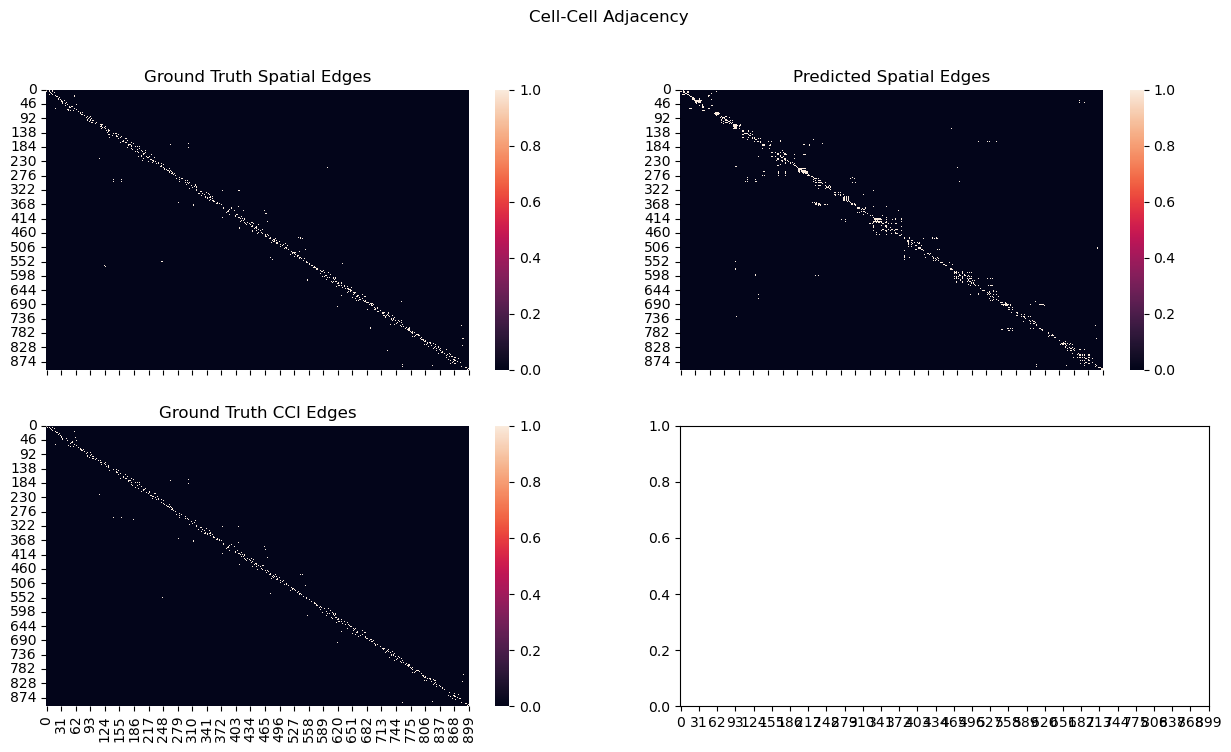

In [31]:
def visualize_cell_adjacency(cell_gt_adjacency, cell_embeddings, cci_adjacency, num_cells=900):
    
    pred_cell_heatmap = torch.sigmoid(torch.matmul(cell_embeddings, cell_embeddings.t())).detach().numpy()
    
    pred_cell_heatmap = pred_cell_heatmap > 0.95
    
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,8))
    fig.suptitle('Cell-Cell Adjacency')
    axes[0,0].set_title('Ground Truth Spatial Edges')
    axes[0,1].set_title('Predicted Spatial Edges')
    axes[1,0].set_title('Ground Truth CCI Edges')

    sns.heatmap(cell_gt_adjacency[:num_cells,:num_cells], ax = axes[0,0])
    sns.heatmap(pred_cell_heatmap[:num_cells,:num_cells], ax = axes[0,1])
    sns.heatmap(cci_adjacency[:num_cells,:num_cells], ax = axes[1,0])
    # return fig

cell_gt_adjacency = np.load(os.path.join(preprocess_output_path, "celllevel_adjacencymatrix.npy"))
cci_adjacency = pd.read_csv(os.path.join(raw_data_path, "adj.csv")).to_numpy()

visualize_cell_adjacency(cell_gt_adjacency, z, cci_adjacency)


## Evaluate GRN Refinement

In [10]:
# import umap

# numsubgraphs = 20
# genespercell = 45

# cellnumbers = []

# gae_gene_embeddings = z_g[:genespercell*numsubgraphs, :].detach().numpy()
# print(f"Selected {gae_gene_embeddings.shape[0]} out of {z_g.shape[0]} genes")

# for i in range(numsubgraphs):
#     val = f'Cell{i}'
#     for j in range(genespercell):
#         cellnumbers.append(val)

# umap_manifold = umap.UMAP(n_neighbors=20, random_state=42).fit(gae_gene_embeddings)

# df = pd.DataFrame({"UMAP1":umap_manifold.embedding_[:, 0], "UMAP2":umap_manifold.embedding_[:, 1], "Cell #":cellnumbers})
# df


In [25]:
graphsaint_gene_embeddings = torch.load(os.path.join(preprocess_output_path, "graphsaint_gcn_embeddings.pth")).detach().numpy()
np.save(os.path.join(preprocess_output_path, "genelevel_features"), graphsaint_gene_embeddings)

In [58]:
import umap

def project_genes(embeddings, num_cells, num_genespercell, type):
    cellnumbers = []
    gae_gene_embeddings = None

    if type == "None":
        for i in range(num_cells):
            val = f'Cell{i}'
            for j in range(num_genespercell):
                cellnumbers.append(val)

        gae_gene_embeddings = embeddings[:num_genespercell*num_cells]
        print(f"Selected {gae_gene_embeddings.shape[0]} out of {embeddings.shape[0]} genes")

        
    elif type == "pool":
        for i in range(num_cells):
            val = f'Cell{i}'
            cellnumbers.append(val)
            
        gae_gene_embeddings = embeddings[:num_cells, :]
    #    print(f"Selected {gae_gene_embeddings.shape[0]} out of {embeddings.shape[0]} cells")
    elif type == "concat":
        for i in range(num_cells):
            val = f'Cell{i}'
            cellnumbers.append(val)
            
        gae_gene_embeddings = embeddings[:num_genespercell*num_cells, :]
        print(gae_gene_embeddings.shape)
        gae_gene_embeddings = np.reshape(gae_gene_embeddings, (gae_gene_embeddings.shape[0]//num_genespercell, gae_gene_embeddings.shape[1] * num_genespercell))
        

    assert gae_gene_embeddings is not None

    umap_manifold = umap.UMAP(n_neighbors=num_cells, random_state=42).fit(gae_gene_embeddings)

    df = pd.DataFrame({"UMAP1":umap_manifold.embedding_[:, 0], "UMAP2":umap_manifold.embedding_[:, 1], "Cell #":cellnumbers})

    return df
  
num_cells = 20
num_genespercell = 45


# pred_grnumap_df= project_genes(gene_embeddings.detach().numpy(), num_cells=num_cells, num_genespercell=num_genespercell, type="None")
pred_grnumap_df= project_genes(combined_gene_embeddings.detach().numpy(), num_cells=num_cells, num_genespercell=num_genespercell, type="None")

gt_grnumap_df= project_genes(data[1].x.detach().numpy(), num_cells=num_cells, num_genespercell=num_genespercell, type="None")
# gt_grnumap_df= project_genes(graphsaint_gene_embeddings ,num_cells=num_cells, num_genespercell=num_genespercell, type="None")

display(gt_grnumap_df)
display(pred_grnumap_df)

Selected 900 out of 71865 genes
Selected 900 out of 71865 genes


,UMAP1,UMAP2,Cell #
0,9.987990,-2.491629,Cell0
1,9.843216,-2.392022,Cell0
2,18.472458,11.380923,Cell0
3,18.289911,11.562228,Cell0
4,18.921478,10.939605,Cell0
...,...,...,...
895,-1.922157,21.475586,Cell19
896,-1.894709,21.425371,Cell19
897,-1.985719,21.558319,Cell19
898,-2.025847,21.491463,Cell19


,UMAP1,UMAP2,Cell #
0,11.230071,-1.621966,Cell0
1,11.228853,-1.609408,Cell0
2,11.219952,-1.591803,Cell0
3,8.982882,0.295552,Cell0
4,9.041621,0.236953,Cell0
...,...,...,...
895,15.371800,8.218041,Cell19
896,14.218616,11.162133,Cell19
897,13.590439,12.486523,Cell19
898,15.295181,8.137354,Cell19


In [59]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def visualize_projected_grns(gt_df, pred_df, color = "Cell #"):
    
    display(px.scatter(gt_df,x="UMAP1",y="UMAP2", color=color, title = "Word2Vec GRN UMAP"))
    display(px.scatter(pred_df,x="UMAP1",y="UMAP2", color=color, title = "Predicted GRN UMAP"))


visualize_projected_grns(gt_grnumap_df, pred_grnumap_df)


In [24]:
genelevel_edges = np.load(os.path.join(preprocess_output_path, "genelevel_edgelist.npy")).T
genelevel_graph = nx.from_edgelist(genelevel_edges)
genelevel_graph

In [13]:
genelevel_adjmatrix = nx.to_numpy_array(genelevel_graph)
genelevel_adjmatrix.shape

(71865, 71865)

In [10]:
from scipy.linalg import block_diag

def create_intracellular_gene_mask(num_cells, num_genespercell):
  one_block = np.ones(shape=(num_genespercell,num_genespercell))
  block_list = [one_block for _ in range(num_cells)]
  return block_diag(*block_list)

intracellular_gene_mask = create_intracellular_gene_mask(1597, 45)
intracellular_gene_mask.shape

(71865, 71865)

In [12]:
genelevel_adjmatrix_masked = genelevel_adjmatrix[intracellular_gene_mask.astype(bool)]
np.save()

(3233925,)

In [14]:
genelevel_adjmatrix[intracellular_gene_mask.astype(bool)]

array([1., 1., 1., ..., 0., 0., 1.])

In [24]:
recon_grns = []
for i in range(z_g.shape[0]):
    z_gi = z_g[i].unsqueeze(1)
    recon_grns.append(z_gi @ z_gi.T)
    # 
torch.stack(recon_grns,dim=0).shape

torch.Size([1597, 32, 32])

In [15]:
np.load(os.path.join(preprocess_output_path, "initial_grns.npy")).flatten().shape

(3233925,)

In [13]:
data[1].y

tensor([ 0.8856, -0.0105, -0.0000,  ..., -0.0000, -0.0000,  0.9034])